## **Set-up and Data Loading**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import streamlit as st

In [2]:
df = pd.read_csv('Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,numAdminTickets,numTechTickets
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.515689,0.419566
std,0.368612,24.559481,30.090047,1.275299,1.250117
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,0.000000,0.000000
75%,0.000000,55.000000,89.850000,0.000000,0.000000
max,1.000000,72.000000,118.750000,5.000000,9.000000


### **Data Cleaning**

In [6]:
# checking for duplicate values
df.duplicated().sum()

0

In [7]:
# cleaning column names
df.columns = (
    df.columns.str.strip()                             # Remove leading/trailing spaces
              .str.replace(' ', '_')                   # Replace spaces with underscores
              .str.replace(r'\W+', '', regex=True)     # Remove non-alphanumeric characters
              .str.lower())                             # Lowercase everything
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'numadmintickets',
       'numtechtickets', 'churn'],
      dtype='object')

### Analysis to answer questions on customer churn

#### Q1: What is the overall **churn rate** and how much **revenue** is being lost?


In [8]:
# Churn Rate
churn_rate = df['churn'].value_counts(normalize=True)['Yes'] 
print(f"Churn Rate: {churn_rate:.2%}")

# Revenue at risk
avg_monthly_charge = df[df['churn'] == 'Yes']['monthlycharges'].mean()
lost_revenue = avg_monthly_charge * df[df['churn'] == 'Yes'].shape[0]
print(f"Estimated Monthly Revenue Lost to Churn: ${lost_revenue:.2f}")

Churn Rate: 26.54%
Estimated Monthly Revenue Lost to Churn: $139130.85


#### Q2: What service usage behaviour are associated with higher churn?


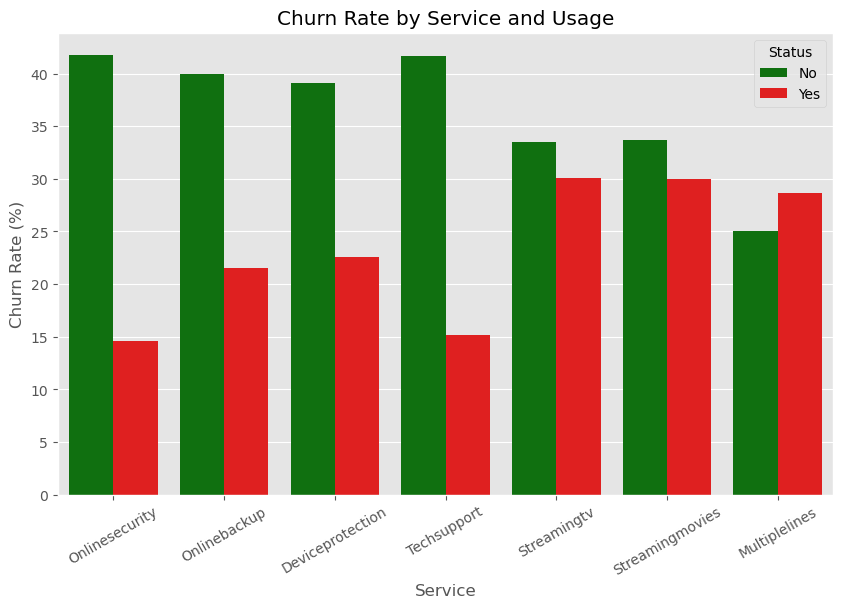

In [23]:
services = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

def churn_rates_grouped(df, service_cols):
    data = []

    for service in service_cols:
        if service in df.columns:
            # Exclude 'No internet service' and 'No phone service'
            valid_statuses = df[service][~df[service].isin(['No internet service', 'No phone service'])].unique()

            for status in valid_statuses:
                if pd.isna(status):
                    continue
                total = len(df[df[service] == status])
                churned = len(df[(df[service] == status) & (df['churn'] == 'Yes')])
                rate = (churned / total) * 100 if total > 0 else 0
                data.append({
                    'Service': service.replace('_', ' ').title(),
                    'Status': status,
                    'Churn Rate (%)': rate
                })
    return pd.DataFrame(data)

#Function to plot the grouped bar chart
def plot_grouped_bar_chart(data):
    style.use('ggplot')
    plt.figure(figsize=(10, 6))
    palette = {'No': 'green', 'Yes': 'red'}
    sns.barplot(data=data, x='Service', y='Churn Rate (%)', hue='Status', palette=palette)
    plt.title('Churn Rate by Service and Usage')
    plt.ylabel('Churn Rate (%)')
    plt.xlabel('Service')
    plt.xticks(rotation=30)
    plt.legend(title='Status')
    plt.show()

grouped_data = churn_rates_grouped(df, services)
plot_grouped_bar_chart(grouped_data)

Findings:

* Multiple Lines: Among customers with multiple lines, the churn rate is particularly high: more customers churn than remain.
* Streaming Services: Customers who subscribe to Streaming TV and Streaming Movies have notably higher churn rates compared to customers using other services.
* Online Backup & Device Protection: Users of Online Backup and Device Protection services show moderately lower churn rates compared to users of most other services.
* Online Security & Tech Support: The lowest churn rates are observed among customers subscribed to Online Security and Technical Support, indicating strong retention within these service groups.

### Q3: What customer groups are associated with higher churn?

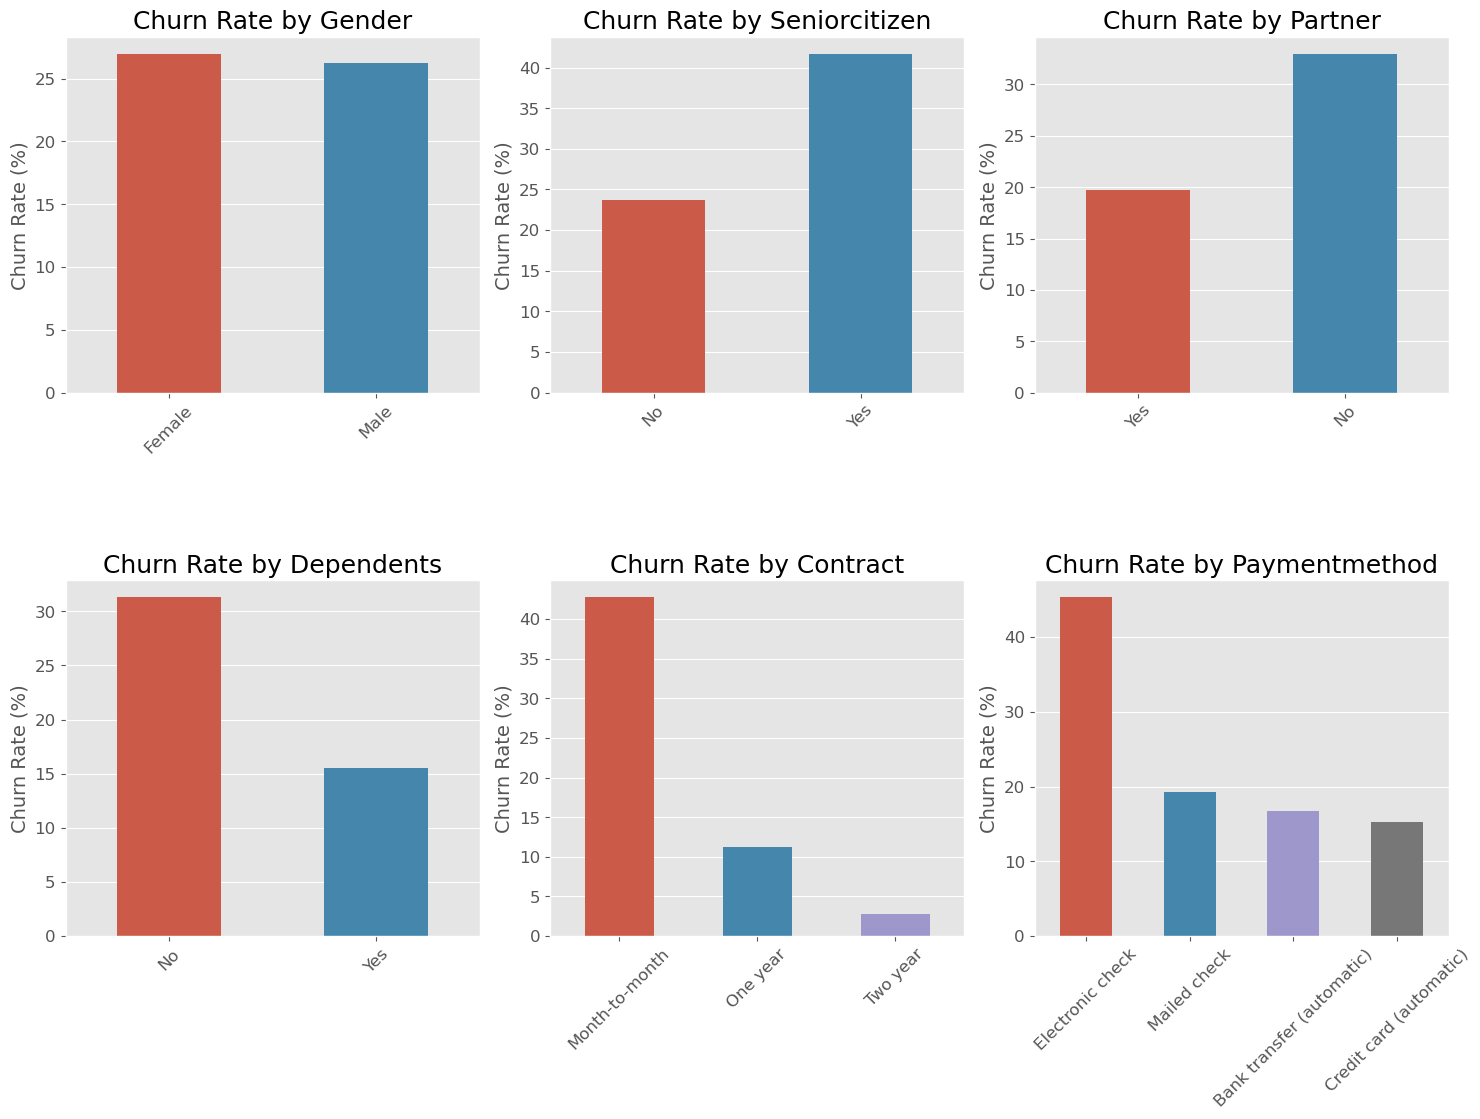

In [27]:
customer_groups = ['gender', 'seniorcitizen', 'partner', 'dependents', 'contract', 'paymentmethod']

# Function to compute churn rates by segments
def churn_rates_by_segments(df, segment_cols):
    data = []
    for segment in segment_cols:
        if segment in df.columns:
            for group in df[segment].dropna().unique():
                total = len(df[df[segment] == group])
                churned = len(df[(df[segment] == group) & (df['churn'] == 'Yes')])
                rate = (churned / total) * 100 if total > 0 else 0
                data.append({
                    'Segment': segment.replace('_', ' ').title(),
                    'Group': str(group),
                    'Churn Rate (%)': rate
                })
    return pd.DataFrame(data)

#  Plotting function
def plot_churn_subplots(df, segments):
    segment_churn_data = churn_rates_by_segments(df, segments)

    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  
    axes = axes.flatten()

    for i, segment in enumerate(segments):
        ax = axes[i]
        segment_data = segment_churn_data[segment_churn_data['Segment'] == segment.replace('_', ' ').title()]
        sns.barplot(data=segment_data, x='Group', y='Churn Rate (%)', hue='Group', ax=ax, width=0.5)
        ax.set_title(f'Churn Rate by {segment.replace("_", " ").title()}', fontsize=18)
        ax.set_xlabel('')
        ax.set_ylabel('Churn Rate (%)', fontsize=14)
        ax.tick_params(axis='x', rotation=45, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
    
    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Run the plotting
plot_churn_subplots(df, customer_groups)

Findings:
* Gender: Churn rates are similar between male and female customers.
* Senior Citizens: Senior citizens are almost twice as likely to churn compared to non-seniors.
* Partner Status: Customers without partners churn at nearly twice the rate of those with partners.
* Dependents: Customers without dependents are over twice as likely to churn than those with dependents.
* Contract Type: Month-to-month contracts have the highest churn rate, while two-year contracts have the lowest.
* Payment Method: Customers using electronic check churn at twice the rate of other methods. Credit card users churn the least.

### Q4: Are certain customer behavior linked to churn?


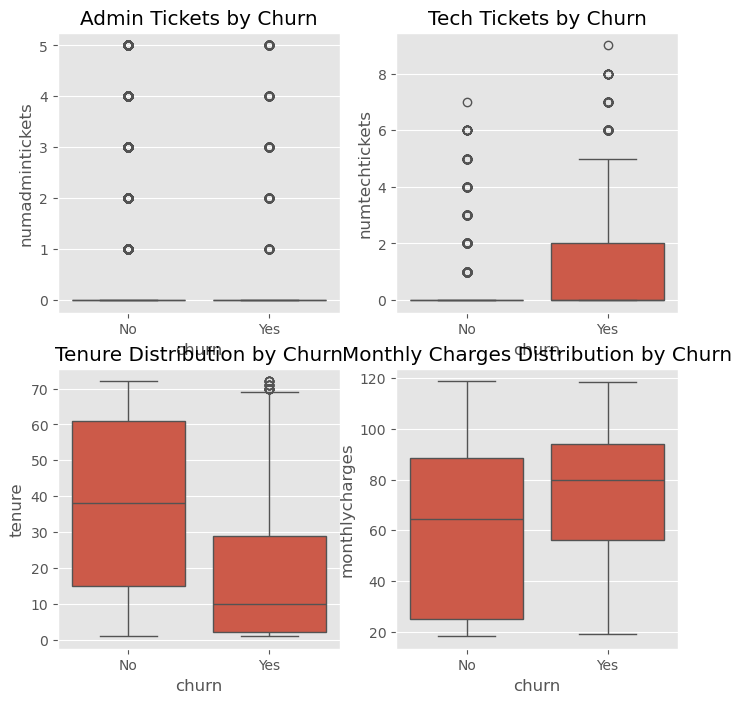

In [28]:
df['seniorcitizen'] = df['seniorcitizen'].replace({0: 'No', 1: 'Yes'})

customer_groups = ['gender', 'seniorcitizen', 'partner', 'dependents', 'contract', 'paymentmethod']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

# Admin Tickets plot
sns.boxplot(data=df, x='churn', y='numadmintickets', ax=ax1)
ax1.set_title('Admin Tickets by Churn')

# Tech Tickets plot
sns.boxplot(data=df, x='churn', y='numtechtickets', ax=ax2)
ax2.set_title('Tech Tickets by Churn')

# Tenure plot
sns.boxplot(data=df, x='churn', y='tenure', ax=ax3)
ax3.set_title('Tenure Distribution by Churn')

# Monthly Charges plot
sns.boxplot(data=df, x='churn', y='monthlycharges', ax=ax4)
ax4.set_title('Monthly Charges Distribution by Churn')
plt.show()


Findings:

* Admin Tickets: Admin ticket activity is similar across both groups, showing little impact on churn.
* Tech Tickets: Churned customers logged more tech support tickets, indicating possible dissatisfaction or recurring issues.
* Tenure: Newer customers are more likely to churn, with an average tenure of 10 months. Some exceptions stayed over 6 years.
* Monthly Charges: Churned customers have higher median monthly charges, suggesting a link between higher costs and churn.

### Q5: Can we predict churn and identify at-risk customers early?


In [29]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce') 
df = df.dropna()
# Prepare the feature matrix X by converting categorical variables into dummy/indicator variables, excluding the first category to avoid multicollinearity.
X = pd.get_dummies(df.drop(['churn', 'customerid'], axis=1), drop_first=True) ..
y = df['churn'].map({'Yes': 1, 'No': 0}) # The target variable y is created by mapping the 'churn' column to binary values (1 for 'Yes', 0 for 'No').

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100,         # Number of trees
    max_depth=None,           # Can be tuned
    class_weight='balanced',  # Adjust for class imbalance
    random_state=42,
    n_jobs=-1)
model.fit(X_train_res, y_train_res)

y_proba = model.predict_proba(X_test)[:, 1]

# custom threshold to convert probabilities into class predictions
threshold = 0.3  # Lower than the default 0.5 to increase recall
y_pred_thresh = (y_proba > threshold).astype(int)


y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Confusion Matrix:
 [[909 124]
 [ 92 282]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      1033
           1       0.69      0.75      0.72       374

    accuracy                           0.85      1407
   macro avg       0.80      0.82      0.81      1407
weighted avg       0.85      0.85      0.85      1407

ROC AUC Score: 0.9088359536369331


**Interpretation:** The Random Forest model demonstrates strong performance in predicting customer churn, especially considering that only about 27% of the data are positive for churn, presenting a moderate class imbalance challenge.

* High Accuracy (85%): The model correctly classifies the vast majority of customers, performing well despite the smaller proportion of churn cases. Balanced Precision and Recall:
* Precision (69%) means when the model predicts churn, it’s correct nearly 7 out of 10 times, reducing false alarms.
* Recall (75%) indicates it successfully captures 75% of actual churners, crucial for effective retention efforts.
* Strong F1 Score (72%): This balance between precision and recall shows the model effectively identifies churners while minimizing false positives, key in an imbalanced dataset.
* Excellent AUC-ROC (0.91): Demonstrates the model’s strong ability to discriminate churners from non-churners across various thresholds, confirming its reliability.
* Robust Handling of Class Imbalance: Despite only 27% churn positives, the model maintains strong predictive power without bias towards the majority class.

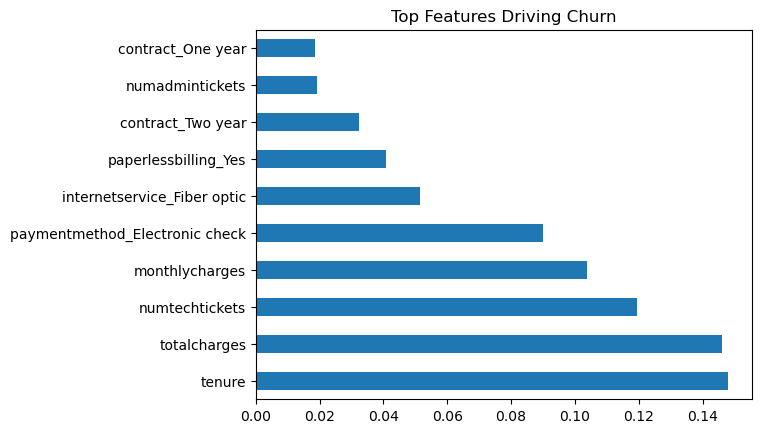

In [18]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top Features Driving Churn')
plt.show()

The top 10 predictors, listed in order of importance, are:
* Tenure
* Total charges
* Number of tech support tickets
* Monthly charges
* Use of electronic check as a payment method
* Fiber optic internet service
* Use of paperless billing
* Two-year contract type
* Number of admin tickets
* One-year contract type.

### **Creating a .py file for a Streamlit Interactive dashboard to present findings**

In [ ]:
%%writefile telecom_dashboard.py


import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Set page config
st.set_page_config(page_title="🔍 Loyalty Lens: Understanding Customer Retention Patterns", layout="centered")

# Title
st.title("🔍 Loyalty Lens: Understanding Customer Retention Patterns")
st.write('''
BigPearl, a telecom company is analyzing customer churn patterns. Customer churn is a critical issue for telecom companies, as retaining existing customers is more cost-effective than acquiring new ones. This project analyzes customer demographic, service usage, and support interaction data to:
* Quantify revenue lost to churn
* Identify high-risk customer segments
* Understand who is churning and why
* Suggest strategies to reduce churn

''')
st.markdown("[Click here to explore the project code on GitHub.](https://github.com/Grace-OO/Call_Metrics/tree/main)")


# Load data
@st.cache_data
def load_data():
    df = pd.read_csv("Churn.csv")
    df.columns = (
    df.columns.str.strip()                             # Remove leading/trailing spaces
              .str.replace(' ', '_')                   # Replace spaces with underscores
              .str.replace(r'\W+', '', regex=True)     # Remove non-alphanumeric characters
              .str.lower())                             # Lowercase everything
    df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
    df['seniorcitizen'] = df['seniorcitizen'].replace({0: 'No', 1: 'Yes'})
    df.dropna(inplace=True)
    return df

df = load_data()

# Sidebar filters
st.sidebar.header("🔍 Filter Data")
contract_filter = st.sidebar.multiselect("Contract Type", df['contract'].unique(), default=df['contract'].unique())
internet_filter = st.sidebar.multiselect("Internet Service", df['internetservice'].unique(), default=df['internetservice'].unique())

filtered_df = df[(df['contract'].isin(contract_filter)) & (df['internetservice'].isin(internet_filter))]

# Base filtered_df to start with all data
filtered_df = df.copy()

# Apply all filters in sequence
for col in ['gender', 'seniorcitizen', 'partner', 'dependents', 'paymentmethod']:
    unique_vals = df[col].dropna().unique().tolist()
    selected_vals = st.sidebar.multiselect(f"{col.title()}", unique_vals, default=unique_vals)
    filtered_df = filtered_df[filtered_df[col].isin(selected_vals)]


# KPI metrics
churn_rate = filtered_df['churn'].value_counts(normalize=True).get('Yes', 0)
monthly_loss = filtered_df[filtered_df['churn'] == 'Yes']['monthlycharges'].sum()

st.metric("Churn Rate", f"{churn_rate:.1%}")
st.metric("Monthly Revenue Lost", f"${monthly_loss:,.0f}")

st.markdown("---")

# Tabs for analysis
tab1, tab2, tab3, tab4 = st.tabs([
    "📝 Executive Summary",
    "📊 Churn by Service",
    "📊 Churn by Customer Segment and Behaviour",
    "📊 Churn Prediction"
 ])
with tab1:
    st.write('''
    ### Executive Summary
    
    This project developed a Random Forest model to predict telecom customer churn for BigPearl.
    The current **churn rate stands at 26.6%**, resulting in an estimated **monthly revenue loss of \$139,131**.
    
    **Key Model Findings:**
    
    * Customers with **shorter tenure** are more likely to churn.
    * Higher **monthly** and **total charges** increase churn risk.
    * Frequent **technical support tickets** signal dissatisfaction and correlate with higher churn.
    * Use of **electronic checks** as a payment method doubles churn risk compared to other methods.
    * Customers using **fiber optic internet** are more prone to churn.
    * **Month-to-month contracts** have the highest churn, while **two-year contracts** show strong retention.
    
    **Service-Related Insights:**
    
    * Customers with **multiple phone lines** experience higher churn rates.
    * Subscribers to **streaming TV and movies** show increased churn.
    * Users of **online security, technical support, online backup,** and **device protection** services have lower churn rates, indicating these services help retain customers.
    
    **Customer Segment Findings:**
    
    * Churn rates are similar for **male and female** customers.
    * **Senior citizens** have nearly twice the churn rate of younger customers.
    * Customers **without partners** are almost twice as likely to churn as those with partners.
    * Customers **without dependents** churn at more than twice the rate of those with dependents.
    
    **Behavioral Patterns:**
    
    * Customers who churn tend to have **higher monthly charges** and an average tenure of **10 months**.
    * They log more **technical support tickets**, while **administrative ticket** activity does not significantly impact churn.
    
    ---
    
    ### Business Recommendations
    
    * Enhance **onboarding and engagement** programs to retain newer customers.
    * Review and optimize **pricing strategies**, including personalized plans and bundles.
    * Improve the **quality and responsiveness of technical support** to address customer issues quickly.
    * Promote and expand **retention services** such as online security and device protection.
    * Incentivize **longer-term contracts** to increase customer loyalty.
    * Investigate and address pain points with **payment methods**, especially electronic checks.
    * Target high-risk groups—**senior citizens, customers without partners or dependents, those with multiple lines, and streaming service subscribers**—with personalized retention campaigns.
    
    ''')
    
with tab2:
    st.subheader("Churn vs Services")

    services = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
    selected_services = st.multiselect("Select services to view", services, default=services)    
    def churn_rates_grouped(df, service_cols):
        data = []

        for service in service_cols:
            if service in df.columns:
            # Exclude 'No internet service' and 'No phone service'
                valid_statuses = df[service][~df[service].isin(['No internet service', 'No phone service'])].unique()

                for status in valid_statuses:
                    if pd.isna(status):
                        continue
                    total = len(df[df[service] == status])
                    churned = len(df[(df[service] == status) & (df['churn'] == 'Yes')])
                    rate = (churned / total) * 100 if total > 0 else 0
                    data.append({
                        'Service': service.replace('_', ' ').title(),
                        'Status': status,
                        'Churn Rate (%)': rate
                    })
        return pd.DataFrame(data)

    def plot_grouped_bar_chart(data):
        style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 6))
        pal = {'No': 'green', 'Yes': 'red'}  # Removed colors for filtered-out values
        sns.barplot(data=data, x='Service', y='Churn Rate (%)', hue= 'Status', palette= pal, ax=ax)
        ax.set_title('Churn Rate by Service and Usage')
        ax.set_ylabel('Churn Rate (%)')
        ax.set_xlabel('Service')        
        plt.xticks(rotation=30)
        st.pyplot(fig)
        
    if selected_services:
        grouped_data = churn_rates_grouped(df, selected_services)
        plot_grouped_bar_chart(grouped_data)

    st.write('''
    **Findings:**

    * Multiple Lines: Among customers with multiple lines, the churn rate is particularly high: more customers churn than remain.

    * Streaming Services: Customers who subscribe to Streaming TV and Streaming Movies have notably higher churn rates compared to customers using other services.

    * Online Backup & Device Protection: Users of Online Backup and Device Protection services show moderately lower churn rates compared to users of most other services.

    * Online Security & Tech Support: The lowest churn rates are observed among customers subscribed to Online Security and Technical Support, indicating strong retention within these service groups.
    ''')
with tab3:
    st.subheader("Churn vs Customer Segment")
    customer_groups = ['gender', 'seniorcitizen', 'partner', 'dependents', 'contract', 'paymentmethod']

    def churn_rates_by_segments(df, segment_cols):
        data = []
        for segment in segment_cols:
            if segment in df.columns:
                for group in df[segment].dropna().unique():
                    total = len(df[df[segment] == group])
                    churned = len(df[(df[segment] == group) & (df['churn'] == 'Yes')])
                    rate = (churned / total) * 100 if total > 0 else 0
                    data.append({
                        'Segment': segment.replace('_', ' ').title(),
                        'Group': str(group),
                        'Churn Rate (%)': rate
                    })
        return pd.DataFrame(data)
    def plot_churn_subplots(df, segments):
        segment_churn_data = churn_rates_by_segments(df, segments)
        rows=3
        cols=3
    
        fig, axes = plt.subplots(rows, cols, figsize=(35, 40))
        axes = axes.flatten()    
        
    
        for i, segment in enumerate(segments):
            ax = axes[i]
            segment_data = segment_churn_data[segment_churn_data['Segment'] == segment.replace('_', ' ').title()]
            
            sns.barplot(data=segment_data, x='Group', y='Churn Rate (%)', hue= 'Group', ax=ax, width= 0.5)
            ax.set_title(f'Churn Rate by {segment.replace("_", " ").title()}', fontsize=30)
            ax.set_xlabel('')
            ax.set_ylabel('Churn Rate (%)', fontsize= 25)            
            ax.tick_params(axis='x', rotation=45, labelsize=25)
            ax.tick_params(axis='y', labelsize=25)
    
        # Remove unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        st.pyplot(fig)

    
    plot_churn_subplots(df, customer_groups)
    st.write('''
    **Findings:**
    
    * Gender: Churn rates are similar between male and female customers.
    
    * Senior Citizens: Senior citizens are almost twice as likely to churn compared to non-seniors.
    
    * Partner Status: Customers without partners churn at nearly twice the rate of those with partners.
    
    * Dependents: Customers without dependents are over twice as likely to churn than those with dependents.
    
    * Contract Type: Month-to-month contracts have the highest churn rate, while two-year contracts have the lowest.
    
    * Payment Method: Customers using electronic check churn at twice the rate of other methods. Credit card users churn the least.
    ''')
        

    st.subheader("Customer Behaviour vs Churn")

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    ax1, ax2, ax3, ax4 = axes.flatten()

# Admin Tickets plot
    sns.boxplot(data=filtered_df, x='churn', y='numadmintickets', ax=ax1)
    ax1.set_title('Admin Tickets by Churn')

# Tech Tickets plot
    sns.boxplot(data=filtered_df, x='churn', y='numtechtickets', ax=ax2)
    ax2.set_title('Tech Tickets by Churn')

# Tenure plot
    sns.boxplot(data=filtered_df, x='churn', y='tenure', ax=ax3)
    ax3.set_title('Tenure Distribution by Churn')

# Monthly Charges plot
    sns.boxplot(data=filtered_df, x='churn', y='monthlycharges', ax=ax4)
    ax4.set_title('Monthly Charges Distribution by Churn')

    st.pyplot(fig)
    st.write('''
    **Findings:**
    
    * Monthly Charges: Churned customers have higher median monthly charges, suggesting a link between higher costs and churn.

    * Tenure: Newer customers are more likely to churn, with an average tenure of 10 months. Some exceptions stayed up to 6 years.

    * Tech Tickets: Churned customers logged more tech support tickets, indicating possible dissatisfaction or recurring issues.

    * Admin Tickets: Admin ticket activity is similar across both groups, showing little impact on churn.
    ''')
    
with tab4:
    st.subheader("🔍 Top Features Driving Churn")
    st.write('Using a Random Forest Model to understand the factors driving churn, these factors have been identified and ranked with level of importance.')
    # Prepare data
    X = pd.get_dummies(filtered_df.drop(['churn', 'customerid'], axis=1), drop_first=True)
    y = filtered_df['churn'].map({'Yes': 1, 'No': 0})

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model = RandomForestClassifier(n_estimators=100,         # Number of trees
    max_depth=None,           # Can be tuned
    class_weight='balanced',  # Adjust for class imbalance
    random_state=42,
    n_jobs=-1)
    model.fit(X_train_res, y_train_res)

    y_proba = model.predict_proba(X_test)[:, 1]

    #custom threshold to convert probabilities into class predictions
    threshold = 0.3  # Lower than the default 0.5 to increase recall
    y_pred_thresh = (y_proba > threshold).astype(int)


    y_pred = model.predict(X_test)
    conf= confusion_matrix(y_test, y_pred)
    report_dict= classification_report(y_test, y_pred, output_dict=True)
    roc =roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) 

       
    # Plot feature importance   
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
   
    fig_imp, ax_imp = plt.subplots()
    importances.head(10).plot(kind='barh', ax=ax_imp)
    ax_imp.set_title("Top 10 Features Influencing Churn")
    ax_imp.invert_yaxis()  
    st.pyplot(fig_imp)

    st.write('''
    The top 10 predictors, listed in order of importance, are:    
    * Tenure
    * Total charges
    * Number of tech support tickets
    * Monthly charges
    * Use of electronic check as a payment method
    * Fiber optic internet service
    * Use of paperless billing
    * Two-year contract type
    * Number of admin tickets
    * One-year contract type.
    ''')
    
    report_df = pd.DataFrame(report_dict).transpose()
    st.write('##### **Model Performance Evaluation:**')
    st.write("**Classification Report**")
    st.dataframe(report_df.style.format("{:.2f}"))   # preserves formatting of the report

    st.write("**ROC AUC Score**")
    st.write(f"{roc:.3f}")
    st.write('''
    **Interpretation:**
    The Random Forest model demonstrates strong performance in predicting customer churn, especially considering that only about 27% of the data are positive for churn, presenting a moderate class imbalance challenge.
    * High Accuracy (85%): The model correctly classifies the vast majority of customers, performing well despite the smaller proportion of churn cases.
    Balanced Precision and Recall:
    * Precision (69%) means when the model predicts churn, it’s correct nearly 7 out of 10 times, reducing false alarms.
    * Recall (75%) indicates it successfully captures 75% of actual churners, crucial for effective retention efforts.
    * Strong F1 Score (72%): This balance between precision and recall shows the model effectively identifies churners while minimizing false positives, key in an imbalanced dataset.
    * Excellent AUC-ROC (0.91): Demonstrates the model’s strong ability to discriminate churners from non-churners across various thresholds, confirming its reliability.
    * Robust Handling of Class Imbalance: Despite only 27% churn positives, the model maintains strong predictive power without bias towards the majority class.
    ''') 

st.write("📌 **Note: This case study was created for a fictional company and is intended solely to demonstrate my process and skills.**")
# Display filtered data
with st.expander("📄 View Filtered Data"):
    st.dataframe(filtered_df)
